In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-06-17'
end_day_to_analyze = '2020-06-18'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,4713,1531,AXDX,buy,443,11.75,"{'avg': 11.5501, 'rsi': 59.85801211875488, 'ma...",2020-06-17 14:39:34.681983+00:00,2020-06-17 14:39:35.062063,11.55,12.21
1,4719,1531,AXDX,sell,443,11.79,"{'avg': 11.6226, 'rsi': [51.48072305233842, 53...",2020-06-17 15:21:20.542512+00:00,2020-06-17 15:21:20.967543,11.55,12.21
2,4706,1531,CLDX,buy,277,10.87,"{'avg': 10.7691, 'rsi': 59.82764325005321, 'ma...",2020-06-17 14:29:52.450922+00:00,2020-06-17 14:29:52.732009,10.53,11.58
3,4711,1531,CLDX,sell,138,10.95,"{'avg': 10.7776, 'rsi': [57.75653698721732, 62...",2020-06-17 14:37:08.772877+00:00,2020-06-17 14:37:09.141493,10.53,11.58
4,4712,1531,CLDX,sell,69,11.02,"{'avg': 10.7814, 'rsi': [61.87108332278668, 64...",2020-06-17 14:37:14.233803+00:00,2020-06-17 14:37:14.698159,10.53,11.58
5,4736,1531,CLDX,sell,35,11.03,"{'avg': 10.8517, 'rsi': [55.294387033921154, 6...",2020-06-17 17:46:06.405362+00:00,2020-06-17 17:46:06.820598,10.53,11.58
6,4737,1531,CLDX,sell,17,11.06,"{'avg': 10.8532, 'rsi': [65.23779886015161, 68...",2020-06-17 17:46:11.309012+00:00,2020-06-17 17:46:11.921124,10.53,11.58
7,4738,1531,CLDX,sell,9,11.06,"{'avg': 10.8532, 'rsi': [65.23779886015161, 68...",2020-06-17 17:46:12.432679+00:00,2020-06-17 17:46:13.109071,10.53,11.58
8,4739,1531,CLDX,sell,4,11.06,"{'avg': 10.8537, 'rsi': [65.23779886015161, 69...",2020-06-17 17:46:13.424520+00:00,2020-06-17 17:46:13.804425,10.53,11.58
9,4740,1531,CLDX,sell,1,11.07,"{'avg': 10.8538, 'rsi': [65.23779886015161, 69...",2020-06-17 17:46:14.454430+00:00,2020-06-17 17:46:14.942051,10.53,11.58


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [8]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1530,momentum_long,PAPER,v0.1-527-g29d8052,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-17 13:50:25.674617,None,None,ae0e26a5-065a-44c0-9440-872a3ae51fcf
1531,momentum_long,PAPER,v0.1-528-g7dc1362,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-17 14:05:17.295917,None,None,808474f6-512c-492b-a006-1e7eca46f9d7


In [9]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [10]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [11]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
7,EBR,2,-1433.70
3,HIBS,3,-853.20
6,ETTX,2,-118.80
5,HEAR,2,-111.89
4,AXDX,2,17.72
0,CLDX,12,33.69
1,XRF,11,40.30
2,OCFT,10,84.29


TOTAL REVENUE: -2341.59 $ for 808474f6-512c-492b-a006-1e7eca46f9d7


In [12]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

CLDX analysis for run 1531 with profit 33.69


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3010.99,-3010.99,buy,2020-06-17 14:29:52.732009,10.87,[10.58],[11.02],277,"{'avg': 10.7691, 'rsi': 59.82764325005321, 'macd': [-0.023955619709850495, -0.016841138679971834, -0.009631318628871455, 0.001104937179015053, 0.011099383328454948], 'vwap': 10.88, 'supports': [10.02, 10.58, 10.8], 'sell_macd': [-0.018135328752668656, -0.013144050474133806, -0.008143781030158337, -0.0009001453461490172, 0.005794897334197913], 'slow macd': [0.05923422160045888, 0.058315090471372955, 0.05766567780047538, 0.05797396997683002, 0.05848475942820386], 'macd_signal': [-0.02247478429544016, -0.021348055172346496, -0.019004707863651486, -0.014982778855118178, -0.009766346418403552], 'resistances': [11.02, 11.05, 11.05], 'position_ratio': '1.75', 'sell_macd_signal': [-0.019021585274677937, -0.01784607831456911, -0.015905618857686956, -0.012904524155379368, -0.009164639857463911]}",11.58,10.53
1,-1499.89,1511.10,sell,2020-06-17 14:37:09.141493,10.95,None,None,138,"{'avg': 10.7776, 'rsi': [57.75653698721732, 62.78335739700655], 'vwap': 10.9308, 'reasons': 'scale-out', 'movement': 0.007828886844526277, 'sell_macd': [0.010086351160538243, 0.015582028159958128, 0.01758408779379117, 0.019435250004651294, 0.024526606922146144], 'sell_macd_signal': [-0.0011340065073705626, 0.0022092004260951758, 0.005284177899634375, 0.00811439232063776, 0.011396835240939436]}",11.58,10.53
2,-739.51,760.38,sell,2020-06-17 14:37:14.698159,11.02,None,None,69,"{'avg': 10.7814, 'rsi': [61.87108332278668, 64.93605624743259], 'vwap': 10.9894, 'reasons': 'scale-out', 'movement': 0.003652968036529765, 'sell_macd': [0.015582028159958128, 0.01758408779379117, 0.019435250004651294, 0.023742191337730034, 0.02938731196950961], 'sell_macd_signal': [0.0022092004260951758, 0.005284177899634375, 0.00811439232063776, 0.011239952124056214, 0.014869424093146894]}",11.58,10.53
3,-353.46,386.05,sell,2020-06-17 17:46:06.820598,11.03,None,None,35,"{'avg': 10.8517, 'rsi': [55.294387033921154, 65.23779886015161], 'vwap': 11.025, 'reasons': 'scale-out', 'movement': 0.0004537205081670401, 'sell_macd': [-0.006045116171145892, -0.003899488357003378, -0.002696408393294547, -0.0006849641567256981, 0.004787394523155797], 'sell_macd_signal': [-0.0048394916394149026, -0.004651490982932598, -0.004260474465004988, -0.00354537240334913, -0.0018788190180481445]}",11.58,10.53
4,-165.44,188.02,sell,2020-06-17 17:46:11.921124,11.06,None,None,17,"{'avg': 10.8532, 'rsi': [65.23779886015161, 68.73284710246175], 'vwap': 11.0486, 'reasons': 'scale-out', 'movement': 0.002719854941069913, 'sell_macd': [-0.003899488357003378, -0.002696408393294547, -0.0006849641567256981, 0.004787394523155797, 0.01080757798120402], 'sell_macd_signal': [-0.004651490982932598, -0.004260474465004988, -0.00354537240334913, -0.0018788190180481445, 0.0006584603818022886]}",11.58,10.53
5,-65.90,99.54,sell,2020-06-17 17:46:13.109071,11.06,None,None,9,"{'avg': 10.8532, 'rsi': [65.23779886015161, 68.73284710246175], 'vwap': 11.06, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [-0.003899488357003378, -0.002696408393294547, -0.0006849641567256981, 0.004787394523155797, 0.01080757798120402], 'sell_macd_signal': [-0.004651490982932598, -0.004260474465004988, -0.00354537240334913, -0.0018788190180481445, 0.0006584603818022886]}",11.58,10.53
6,-21.66,44.24,sell,2020-06-17 17:46:13.804425,11.06,None,None,4,"{'avg': 10.8537, 'rsi': [65.23779886015161, 69.17558099134055], 'vwap': 11.0682, 'reasons': 'scale-out', 'movement': 0.0004520795660035267, 'sell_macd': [-0.003899488357003378, -0.002696408393294547, -0.0006849641567256981, 0.004787394523155797, 0.011067318240945312], 'sell_macd_signal': [-0.004651490982932598, -0.004260474465004988, -0.00354537240334913, -0.0018788190180481445, 0.0007104084337505472]}",11.58,10.53
7,-10.59,11.07,sell,2020-06-17 17:46:14.942051,11.07,None,None,1,"{'avg': 10.8538, 'rsi': [65.23779886015161, 69.17558099134055], 'vwap': 

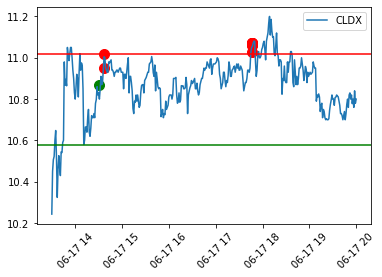

XRF analysis for run 1531 with profit 40.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-776.65,-776.65,buy,2020-06-17 14:35:07.003092,2.45,[2.2668],[2.7113],317,"{'avg': 2.4363, 'rsi': 56.42677216372262, 'macd': [-0.0325445389791823, -0.019615970653258596, -0.00818628355285389, 0.000582688204475712, 0.006417265071848366], 'vwap': 2.4771, 'supports': [2.03, 2.09, 2.2668], 'sell_macd': [-0.023503459234961, -0.014731905123317013, -0.007004305749005901, -0.0010736529151400553, 0.002891448681575426], 'slow macd': [0.032675091344820384, 0.03334975960973008, 0.03413305134868194, 0.03474313614913527, 0.035042549416326896], 'macd_signal': [-0.02107085265686705, -0.02077987625614536, -0.018261157715487066, -0.01449238853149451, -0.010310457810825934], 'resistances': [2.7113], 'position_ratio': '1.11', 'sell_macd_signal': [-0.01740443016483672, -0.016869925156532777, -0.014896801275027401, -0.012132171603049932, -0.009127447546124861]}",3.09,2.17
1,-378.49,398.16,sell,2020-06-17 14:44:51.635713,2.52,None,None,158,"{'avg': 2.4355, 'rsi': [56.559870246662804, 58.28919268786229], 'vwap': 2.5, 'reasons': 'scale-out', 'movement': 0.020408163265306048, 'sell_macd': [0.0002132687466804839, 0.0031039570115996007, 0.005835610763333943, 0.0084026706898368, 0.011338007376854087], 'sell_macd_signal': [-0.0034415534997870646, -0.0021324513975097313, -0.0005388389653409966, 0.0012494629656945627, 0.003267171847926468]}",3.09,2.17
2,-175.46,203.03,sell,2020-06-17 14:45:46.979840,2.57,None,None,79,"{'avg': 2.4371, 'rsi': [60.628524118287174, 64.03860031279773], 'vwap': 2.5794, 'reasons': 'scale-out', 'movement': 0.02265873015873022, 'sell_macd': [0.0031039570115996007, 0.005835610763333943, 0.0084026706898368, 0.012896448935295624, 0.01867736121831154], 'sell_macd_signal': [-0.0021324513975097313, -0.0005388389653409966, 0.0012494629656945627, 0.003578860159614775, 0.006598560371354128]}",3.09,2.17
3,-68.66,106.80,sell,2020-06-17 14:58:47.010422,2.67,None,None,40,"{'avg': 2.4474, 'rsi': [64.44389414480068, 65.4437024538191], 'vwap': 2.6336, 'reasons': 'scale-out', 'movement': 0.024630350194552668, 'sell_macd': [0.015058577544504903, 0.019812434272995283, 0.02252696634359852, 0.026121056705839862, 0.029273321186731316], 'sell_macd_signal': [0.010563644997792138, 0.012413402852832767, 0.014436115550985918, 0.016773103781956705, 0.019273147262911627]}",3.09,2.17
4,-14.86,53.80,sell,2020-06-17 15:35:09.203534,2.69,None,None,20,"{'avg': 2.4667, 'rsi': [67.11302412939428, 69.1029565826522], 'vwap': 2.7, 'reasons': 'scale-out', 'movement': 0.011198501872659191, 'sell_macd': [0.014271748711652599, 0.016953269318111364, 0.019295320838493613, 0.02195542175257703, 0.024776858545985547], 'sell_macd_signal': [0.006069807393629115, 0.008246499778525564, 0.010456263990519174, 0.012756095542930746, 0.015160248143541706]}",3.09,2.17
5,12.64,27.50,sell,2020-06-17 15:35:23.249242,2.75,None,None,10,"{'avg': 2.47, 'rsi': [69.11234832586797, 71.8744302377876], 'vwap': 2.73, 'reasons': 'scale-out', 'movement': 0.014869888475836444, 'sell_macd': [0.016953269318111364, 0.019295320838493613, 0.02195542175257703, 0.024782053351180444, 0.028221220137738978], 'sell_macd_signal': [0.008246499778525564, 0.010456263990519174, 0.012756095542930746, 0.015161287104580685, 0.017773273711212345]}",3.09,2.17
6,26.39,13.75,sell,2020-06-17 15:35:25.769294,2.75,None,None,5,"{'avg': 2.4703, 'rsi': [69.11234832586797, 73.456819626854], 'vwap': 2.75, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.016953269318111364, 0.019295320838493613, 0.02195542175257703, 0.024782053351180444, 0.029260181176699707], 'sell_macd_signal': [0.008246499778525564, 0.010456263990519174, 0.012756095542930746, 0.015161287104580685, 0.017981065919004488]}",3.09,2.17
7,31.95,5.56,sell,2020-06-17 15:35:30.224777,2.78,None,None,2,"{'avg': 2.471, 'rsi': [69.11234832586797, 74.87063761282404], 'vwap': 2.7676, 'reasons': 'scale-out', 'movement': 0.007272727272727279, 'sell_macd': [0.016953269318111364, 0.01929

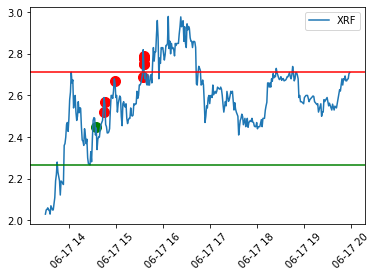

OCFT analysis for run 1531 with profit 84.29


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4488.78,-4488.78,buy,2020-06-17 14:35:19.562352,18.94,[18.61],"[19.26, 19.37]",237,"{'avg': 18.3855, 'rsi': 67.65653084492209, 'macd': [0.08264474886587792, 0.08285035647628902, 0.08166842105451622, 0.08419917340435745, 0.09076658138894089], 'vwap': 18.9625, 'supports': [17.415, 17.755, 17.78, 17.82, 18.53, 18.61], 'sell_macd': [0.04417547782360032, 0.04450913610970275, 0.04393134859095582, 0.04576773041283033, 0.05021468078815161], 'slow macd': [0.11961307740320137, 0.11988176981372334, 0.1198572732752794, 0.12052268885782169, 0.12205368865790334], 'macd_signal': [0.09453686048399298, 0.09219955968245219, 0.090093331956865, 0.08891450024636349, 0.08928491647487898], 'resistances': [19.37], 'position_ratio': '1.11', 'sell_macd_signal': [0.05135186504579755, 0.04998331925857859, 0.04877292512505403, 0.04817188618260929, 0.048580445103717756]}",19.79,18.56
1,-2220.82,2267.96,sell,2020-06-17 14:40:01.949242,19.22,None,None,118,"{'avg': 18.4221, 'rsi': [70.98703401373469, 74.99450496743812], 'vwap': 19.22, 'reasons': 'scale-out', 'movement': 0.014783526927138203, 'sell_macd': [0.04998091455438569, 0.05131611109904455, 0.05013163943126031, 0.05842774411310003, 0.07036720562994958], 'sell_macd_signal': [0.04853369185696457, 0.049090175705380566, 0.049298468450556514, 0.05112432358306522, 0.05497289999244209]}",19.79,18.56
2,-1082.12,1138.70,sell,2020-06-17 15:25:38.030243,19.30,None,None,59,"{'avg': 18.6131, 'rsi': [56.22089879302487, 69.4938255535244], 'vwap': 19.3, 'reasons': 'scale-out', 'movement': 0.004162330905307069, 'sell_macd': [0.007505180801015143, 0.0058465816894575084, 0.005257457944225052, 0.006028823104507808, 0.013304837215059706], 'sell_macd_signal': [0.011080570860698436, 0.010033773026450251, 0.009078510010005212, 0.00846857262890573, 0.009435825546136525]}",19.79,18.56
3,-500.12,582.00,sell,2020-06-17 15:25:54.924125,19.40,None,None,30,"{'avg': 18.6143, 'rsi': [56.22089879302487, 73.77506031090311], 'vwap': 19.3665, 'reasons': 'scale-out', 'movement': 0.003626943005181362, 'sell_macd': [0.007505180801015143, 0.0058465816894575084, 0.005257457944225052, 0.006028823104507808, 0.016941200851423588], 'sell_macd_signal': [0.011080570860698436, 0.010033773026450251, 0.009078510010005212, 0.00846857262890573, 0.010163098273409301]}",19.79,18.56
4,-208.82,291.30,sell,2020-06-17 15:28:35.012857,19.42,None,None,15,"{'avg': 18.6264, 'rsi': [74.57077762092376, 74.42294351896584], 'vwap': 19.42, 'reasons': 'scale-out', 'movement': 0.0010309278350517075, 'sell_macd': [0.005257457944225052, 0.006028823104507808, 0.020442499552721927, 0.03055650068700899, 0.03798875480870123], 'sell_macd_signal': [0.009078510010005212, 0.00846857262890573, 0.010863358013668969, 0.014801986548336973, 0.019439340200409824]}",19.79,18.56
5,-72.25,136.57,sell,2020-06-17 15:38:17.861162,19.51,None,None,7,"{'avg': 18.6502, 'rsi': [64.57284488867674, 72.04348225667978], 'vwap': 19.4715, 'reasons': 'scale-out', 'movement': 0.004119464469618862, 'sell_macd': [0.041702026668840375, 0.04459146340197506, 0.04418594055244185, 0.04381558585732037, 0.049191730434404946], 'sell_macd_signal': [0.027282737582057306, 0.030744482746040858, 0.033432774307321056, 0.03550933661732092, 0.03824581538073772]}",19.79,18.56
6,5.95,78.20,sell,2020-06-17 15:38:34.614000,19.55,None,None,4,"{'avg': 18.6516, 'rsi': [70.7054163708221, 73.36876933631265], 'vwap': 19.5591, 'reasons': 'scale-out', 'movement': 0.0015376729882110498, 'sell_macd': [0.04418594055244185, 0.04381558585732037, 0.049191730434404946, 0.05222259983947808, 0.0565035032740866], 'sell_macd_signal': [0.033432774307321056, 0.03550933661732092, 0.03824581538073772, 0.04104117227248579, 0.04413363847280595]}",19.79,18.56
7,45.19,39.24,sell,2020-06-17 15:39:04.436100,19.62,None,None,2,"{'avg': 18.6544, 'rsi': [70.7054163708221, 75.9884199973013], 'vwap': 19.5998, 'reasons': 'scale-out', 'movement': 0.0025575447570332843, 's

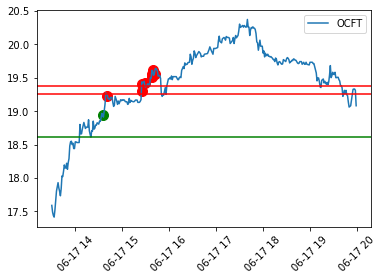

HIBS analysis for run 1531 with profit -853.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3564.0,-3564.0,buy,2020-06-17 14:19:24.112157,6.60,"[6.36, 6.4948]",[6.74],540,"{'avg': 6.4944, 'rsi': 60.96406557255484, 'macd': [0.020783460051584157, 0.02325583823496835, 0.018944956888788056, 0.024126517578945794, 0.02791119883101878], 'vwap': 6.61, 'supports': [6.23, 6.36, 6.4, 6.4948], 'sell_macd': [0.010822180437756401, 0.012487440052397325, 0.009726766504683404, 0.013163556383027242, 0.015670619192347246], 'slow macd': [0.03612862613434231, 0.03652483921283611, 0.03563143135068625, 0.036511776326212164, 0.03726332637954233], 'macd_signal': [0.028806373906496496, 0.027696266772190867, 0.025946004795510305, 0.025582107352197403, 0.026047925647961677], 'resistances': [6.74], 'position_ratio': '1.13', 'sell_macd_signal': [0.01603241126808324, 0.015323417024946056, 0.014204086920893526, 0.013995980813320269, 0.014330908489125663]}",6.97,6.43
1,-1760.4,1803.6,sell,2020-06-17 14:30:28.360510,6.68,None,None,270,"{'avg': 6.5368, 'rsi': [63.20405263294535, 64.68719032223666], 'vwap': 6.68, 'reasons': 'scale-out', 'movement': 0.012121212121212133, 'sell_macd': [0.023813099676297078, 0.023815423455086915, 0.024209241679402638, 0.024554954040175936, 0.025191159074021918], 'sell_macd_signal': [0.01976031512225445, 0.02057133678882094, 0.02129891776693728, 0.021950125021585012, 0.022598331832072393]}",6.97,6.43
2,-853.2,907.2,sell,2020-06-17 19:28:26.315457,6.72,None,None,135,"{'avg': 6.544, 'rsi': [76.13134563917899, 77.73654351547421], 'vwap': 6.7265, 'reasons': 'scale-out', 'movement': 0.006437125748503017, 'sell_macd': [0.014044155321833784, 0.016216850608736344, 0.01778756316205321, 0.019990877318377898, 0.022123448384106403], 'sell_macd_signal': [0.011297086621432232, 0.012281039418893054, 0.013382344167525085, 0.014704050797695647, 0.016187930314977797]}",6.97,6.43


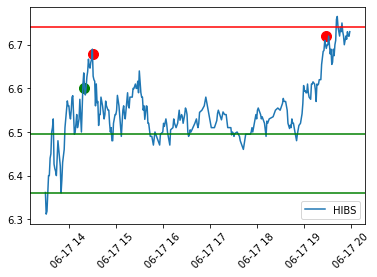

AXDX analysis for run 1531 with profit 17.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5205.25,-5205.25,buy,2020-06-17 14:39:35.062063,11.75,"[11.5, 11.56, 11.6]",[11.96],443,"{'avg': 11.5501, 'rsi': 59.85801211875488, 'macd': [-0.003788650582947639, 0.0024060956263642908, 0.0059956421364937285, 0.009178384933472117, 0.015516107809355972], 'vwap': 11.7695, 'supports': [10.985, 11.014, 11.03, 11.07, 11.17, 11.5, 11.56, 11.6], 'sell_macd': [-0.0064247138360560285, -0.0020763031174748647, 0.0005338390413882621, 0.0028464973594442, 0.007183029849366918], 'slow macd': [0.05986876567624577, 0.059555426043967685, 0.05892399213831112, 0.05833677687023098, 0.05849490184450623], 'macd_signal': [0.004126928589819559, 0.003782761997128505, 0.00422533802500155, 0.0052159474066956635, 0.007275979487227725], 'resistances': [11.96], 'position_ratio': '1.12', 'sell_macd_signal': [-0.0025876591118569915, -0.002485387912980566, -0.0018815425221068004, -0.0009359345457966003, 0.0006878583332361033]}",12.21,11.55
1,17.72,5222.97,sell,2020-06-17 15:21:20.967543,11.79,None,None,443,"{'avg': 11.6226, 'rsi': [51.48072305233842, 53.53660634344967], 'vwap': 11.81, 'reasons': 'bail', 'movement': 0.0051063829787234465, 'sell_macd': [0.015488980700476773, 0.014276903828326581, 0.014185975047061206, 0.01237244645066049, 0.01183758720085848], 'sell_macd_signal': [0.012394838221635202, 0.012771251342973477, 0.013054196083791023, 0.012917846157164917, 0.01270179436590363]}",12.21,11.55


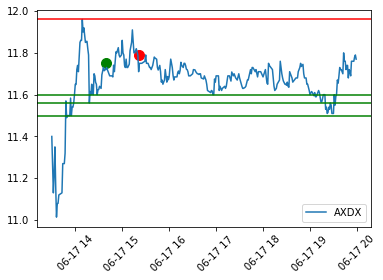

HEAR analysis for run 1531 with profit -111.89


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2454.90,-2454.90,buy,2020-06-17 14:13:24.993295,14.70,[14.42],"[14.705, 14.9765, 15.11]",167,"{'avg': 14.3598, 'rsi': 66.37677603896306, 'macd': [0.08708940051461411, 0.09385829244114063, 0.10744123292555763, 0.10809178478171866, 0.1129457295717966], 'vwap': 14.7099, 'supports': [13.55, 13.6052, 14.1928, 14.42], 'sell_macd': [0.04948602711601069, 0.05394327903593421, 0.06280421197307007, 0.06318410501534366, 0.06629072160652605], 'slow macd': [0.09264871439697941, 0.09497873777258548, 0.09884497881064114, 0.1004862585840609, 0.10295352756618925], 'macd_signal': [0.07839498146513496, 0.08148764366033609, 0.0866783615133804, 0.09096104616704806, 0.09535798284799776], 'resistances': [14.9765, 15.11], 'position_ratio': '0.92', 'sell_macd_signal': [0.04340724138855149, 0.045514448918028035, 0.04897240152903644, 0.05181474222629788, 0.054709938102343515]}",15.87,14.13
1,-111.89,2343.01,sell,2020-06-17 15:05:52.071771,14.03,None,None,167,"{'avg': 14.3873, 'rsi': [24.93000265479833, 21.429085520748526], 'vwap': 14.1202, 'reasons': 'stopped', 'movement': -0.0401360544217687, 'sell_macd': [-0.04008429315526385, -0.044236810784001435, -0.0474175152897196, -0.049799654965736906, -0.05412600205139029], 'sell_macd_signal': [-0.02509912470474866, -0.028926661920599214, -0.032624832594423295, -0.03605979706868602, -0.03967303806522687]}",15.87,14.13


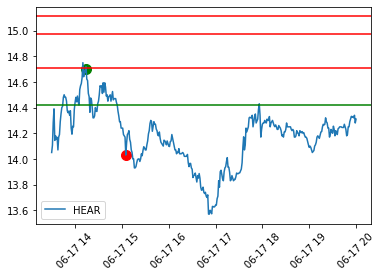

ETTX analysis for run 1531 with profit -118.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1170.0,-1170.0,buy,2020-06-17 14:23:31.269128,3.25,[3.1],"[3.6793, 3.68, 3.68, 3.7399]",360,"{'avg': 3.1644, 'rsi': 60.98240648657358, 'macd': [0.016195346974021252, 0.013289633892530794, 0.00806960644814314, 0.011865088006550284, 0.020287586800099344], 'vwap': 3.2188, 'supports': [2.9901, 3.05, 3.05, 3.06, 3.07, 3.08, 3.1], 'sell_macd': [0.009515918207906093, 0.007618789194227205, 0.004223379713513609, 0.006717562199794802, 0.012210203589107849], 'slow macd': [0.010481038541283905, 0.010244454467533082, 0.009450628889136059, 0.010304529260408035, 0.01219321644043836], 'macd_signal': [0.01057841575463098, 0.011120659382210943, 0.010510448795397382, 0.010781376637627963, 0.012682618670122239], 'resistances': [3.6793, 3.68, 3.68], 'position_ratio': '2.41', 'sell_macd_signal': [0.005795974204392882, 0.006160537202359746, 0.0057731057045905185, 0.005961997003631375, 0.007211638320726669]}",3.81,3.0
1,-118.8,1051.2,sell,2020-06-17 15:45:57.067636,2.92,None,None,360,"{'avg': 3.158, 'rsi': [39.292058574686614, 37.32556769082931], 'vwap': 3.0042, 'reasons': 'stopped', 'movement': -0.07692307692307693, 'sell_macd': [-0.017926976433620734, -0.02022604365114722, -0.021754848708295693, -0.02266359487349856, -0.024116337406468347], 'sell_macd_signal': [-0.0114706802815998, -0.013221752955509283, -0.014928372106066564, -0.016475416659552964, -0.01800360080893604]}",3.81,3.0


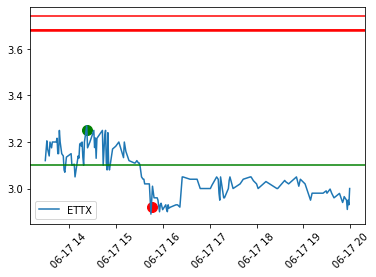

EBR analysis for run 1531 with profit -1433.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2925.72,-2925.72,buy,2020-06-17 14:15:22.531797,6.02,"[5.87, 5.89, 5.9]","[6.22, 6.25, 6.27, 6.27]",486,"{'avg': 5.9437, 'rsi': 67.19318238152971, 'macd': [0.02700414073437951, 0.030913417648679165, 0.03202851018667818, 0.032537160919449803, 0.034958044987354775], 'vwap': 6.02, 'supports': [5.535, 5.56, 5.57, 5.63, 5.87, 5.89, 5.9], 'sell_macd': [0.0147429252227127, 0.01735755902849334, 0.01813055213652426, 0.018497422712437483, 0.02010151117792347], 'slow macd': [0.04108643445129623, 0.04186584111482716, 0.042196089562778205, 0.04243244195001772, 0.04306183702208344], 'macd_signal': [0.02335600021075056, 0.02486748369833628, 0.026299688996004662, 0.02754718338069369, 0.02902935570202591], 'resistances': [6.24, 6.25, 6.27, 6.27], 'position_ratio': '1.83', 'sell_macd_signal': [0.011906506928408047, 0.012996717348425106, 0.014023484306044937, 0.014918271987323446, 0.01595491982544345]}",6.42,5.82
1,-1433.70,1492.02,sell,2020-06-17 14:36:32.985190,6.14,None,None,243,"{'avg': 6.0175, 'rsi': [67.88138115842023, 71.49914364563547], 'vwap': 6.145, 'reasons': 'scale-out', 'movement': 0.020764119601328904, 'sell_macd': [0.02052612405121579, 0.02210172322621684, 0.024081388515488023, 0.024532018760173635, 0.02612300312278304], 'sell_macd_signal': [0.018644564698500767, 0.01933599640404398, 0.020285074826332787, 0.021134463613100958, 0.022132171515037373]}",6.42,5.82


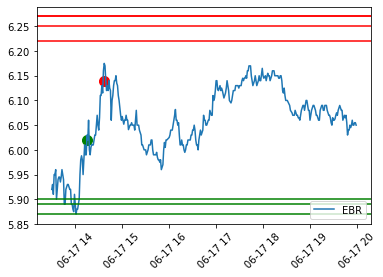

In [14]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))

In [ ]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
minute_history['PERI']

,open,high,low,close,volume
timestamp,,,,,
2020-06-08 07:06:00-04:00,5.7500,5.7500,5.75,5.75,1000
2020-06-08 07:16:00-04:00,5.7500,5.7500,5.75,5.75,180
2020-06-08 09:21:00-04:00,5.8200,5.8200,5.82,5.82,1000
2020-06-08 09:30:00-04:00,5.8400,5.8600,5.80,5.80,22488
2020-06-08 09:31:00-04:00,5.8300,5.8600,5.83,5.86,1662
...,...,...,...,...,...
2020-06-16 15:55:00-04:00,5.6100,5.6200,5.61,5.62,248
2020-06-16 15:57:00-04:00,5.6089,5.6089,5.60,5.60,2503
2020-06-16 15:58:00-04:00,5.6000,5.6000,5.60,5.60,317
